In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
# Model 1 definition

def Model1():
    model = nn.Sequential(
        # Convolutional layer 1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Flatten the output for fully connected layers
        nn.Flatten(),

        # Fully connected layers
        nn.Linear(64 * 6 * 6, 128),  # Adjust the input size based on the output size of the previous layer
        nn.ReLU(),
        nn.Linear(128, 7)  # Adjust the output size based on the number of classes in your classification task
    )

    # Print the model architecture
    print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


In [4]:
model1 = Model1()
model_name = 'model1'
filename = f'{model_name}_weights.pth'
model1.load_state_dict(torch.load(filename))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


<All keys matched successfully>

In [5]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def get_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print("Error opening video stream or file")
        return []

    # Get frames per second (fps) from the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []

    plt.ion()  # Enable interactive mode for real-time image display

    frame_count = 0  # Initialize frame counter

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process only the first frame of each second
        if frame_count % int(fps) == 0:
            # Convert the frame from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append the frame to the list
            frames.append(frame)

            # Display the frame using matplotlib
            plt.imshow(frame)
            plt.pause(0.001)  # Pause briefly to update the plot
            plt.clf()  # Clear the plot to prepare for the next frame

        frame_count += 1  # Increment frame counter

    # Cleanup
    cap.release()
    plt.ioff()  # Turn off interactive mode
    return frames



In [6]:
def preprocess_frames(frames, size=(48, 48), device='cuda'):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust for grayscale
    ])
    
    # Apply transformations and move tensors to CUDA as they're created
    tensor_frames = torch.stack([transform(Image.fromarray(frame)).to(device) for frame in frames])
    return tensor_frames


In [7]:
def model_inference(model, frames, device='cuda'):
    model.eval()
    model.to(device)
    with torch.no_grad():
        outputs = model(frames.to(device))
    return outputs


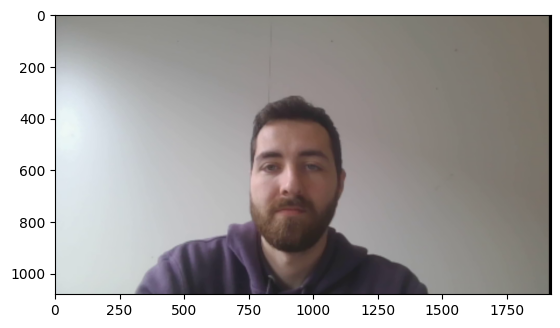

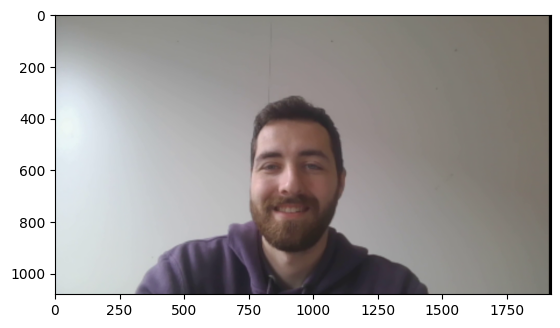

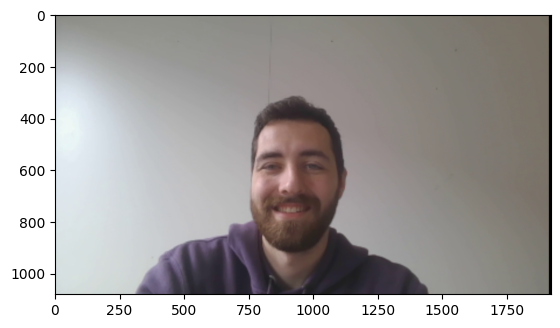

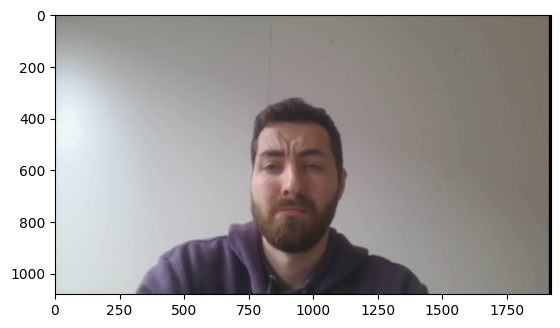

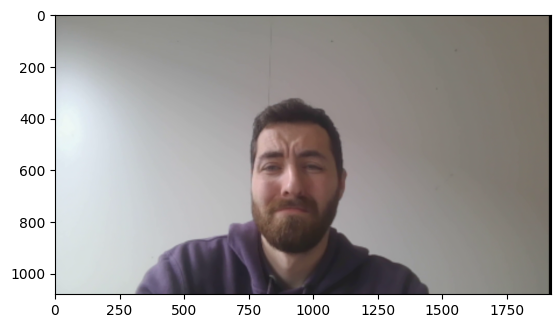

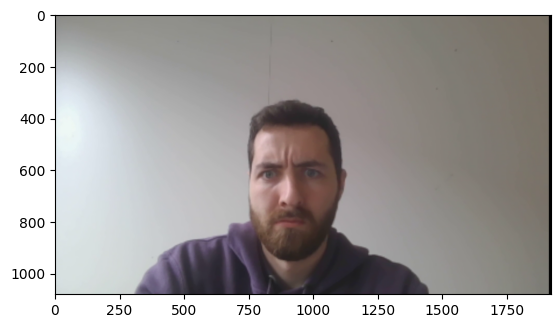

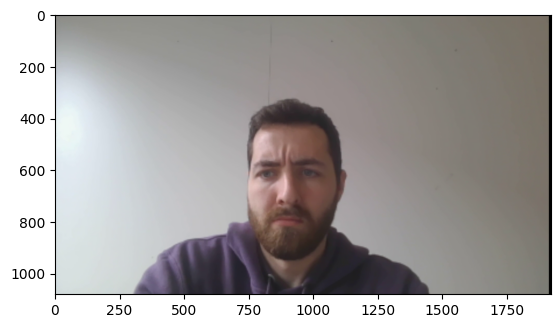

<Figure size 640x480 with 0 Axes>

In [8]:
# Assume the model and data loaders are defined elsewhere
video_path = '2024-05-24 14-53-08.mp4'
frames = get_video_frames(video_path)

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process frames
processed_frames = preprocess_frames(frames, device=device)

# Load and prepare your model
# model = Model1().to(device)

# Get predictions
outputs = model_inference(model1, processed_frames, device=device)



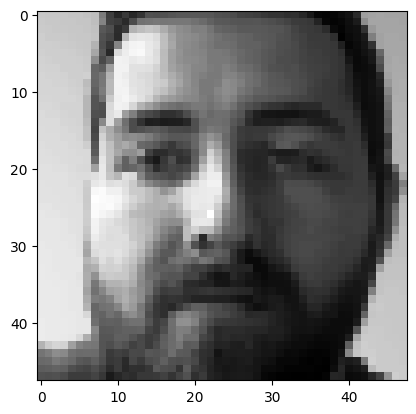

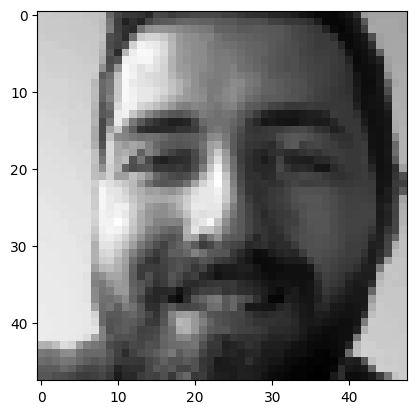

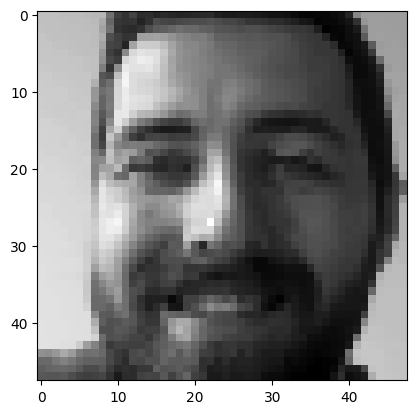

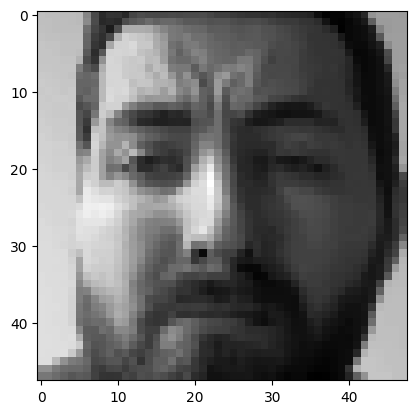

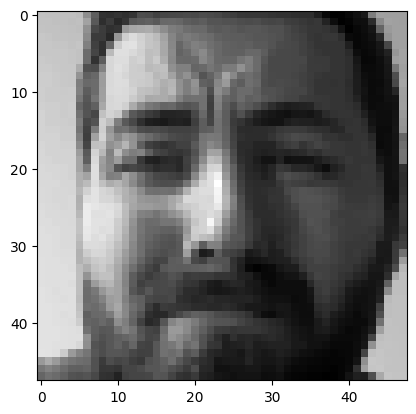

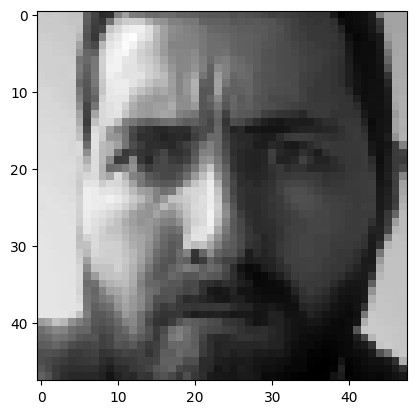

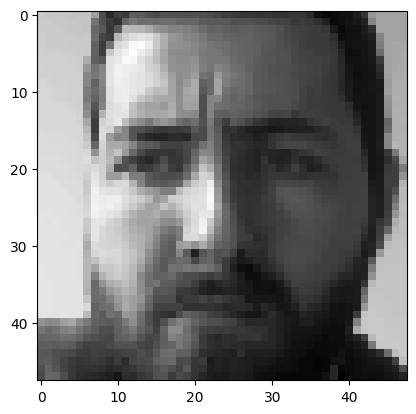

In [9]:
import numpy as np

f_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
# e_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
extr_images = []
for frame in frames:
    image = frame.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = f_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        # roi_gray = gray[y:y+h, x:x+w]
        # roi_color = img[y:y+h, x:x+w]
        # eyes = e_cascade.detectMultiScale(roi_gray)
        # for (ex,ey,ew,eh) in eyes:
        #     cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        extr_img = img[y:y+h,x:x+h]
        extr_final_img = cv2.resize(extr_img, (48, 48))
        extr_final_img_gray = cv2.cvtColor(extr_final_img, cv2.COLOR_BGR2GRAY) 
        # extr_images.append(extr_final_img_gray)
        plt.imshow(extr_final_img_gray, cmap='gray')
        plt.show()
        transform = transforms.Compose([
        # transforms.ToPILImage(),
            transforms.ToTensor()
        ])  
        tensor = transform(extr_final_img_gray)
        tensor = torch.unsqueeze(tensor, dim=0)
        extr_images.append(tensor.cuda())


In [10]:
# evaluate model at end of epoch
def evaluate_model(model, test_image):
    model.eval()
    y_pred = model(test_image)
    y_pred_numpy = torch.argmax(y_pred).detach().cpu().numpy()
    return y_pred_numpy 

In [14]:
emotion_label= {0:'0 (anger)',1:'1 (disgust)',2:'2 (fear)',3:'3 (happiness)',4:'4 (sadness)',5:'5 (surprise)',6:'6 (neutral)'}

for image in extr_images:
    pred = evaluate_model(model1, image)
    print(emotion_label[int(pred)])



torch.Size([1, 1, 48, 48])
3 (happiness)
torch.Size([1, 1, 48, 48])
3 (happiness)
torch.Size([1, 1, 48, 48])
2 (fear)
torch.Size([1, 1, 48, 48])
2 (fear)
torch.Size([1, 1, 48, 48])
2 (fear)
torch.Size([1, 1, 48, 48])
2 (fear)
torch.Size([1, 1, 48, 48])
2 (fear)
